In [1]:
import sys
import os
import time

import jax
import jax.numpy as jnp
from jax import random, jit

# Add the src directory to the path so we can import malthusjax
sys.path.append('/Users/leonardodicaterina/Documents/GitHub/MalthusJAX/src')
from malthusjax.engine.state import MalthusState


In [2]:
# Create a key
key = random.PRNGKey(42)
key, pop_key, best_key = random.split(key, 3)

# Create some dummy data
dummy_pop = random.bernoulli(pop_key, shape=(10, 5)).astype(jnp.float32)
dummy_fitness = jnp.arange(10, dtype=jnp.float32)
dummy_best_genome = random.bernoulli(best_key, shape=(5,)).astype(jnp.float32)

# Instantiate the MalthusState
# Note: It's just a data container.
initial_state = MalthusState(
    population=dummy_pop,
    fitness=dummy_fitness,
    best_genome=dummy_best_genome,
    best_fitness=10.0,
    key=key,
    generation=0
)

print(initial_state)

MalthusState(population=Array([[0., 0., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 0., 0., 0.],
       [1., 1., 0., 1., 1.],
       [1., 0., 1., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 1., 1., 0., 1.],
       [1., 0., 1., 0., 1.],
       [1., 0., 1., 1., 1.],
       [1., 0., 0., 0., 1.]], dtype=float32), fitness=Array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], dtype=float32), best_genome=Array([0., 0., 1., 1., 1.], dtype=float32), best_fitness=10.0, key=Array([1832780943,  270669613], dtype=uint32), generation=0)


In [ ]:
# --- This will FAIL ---
try:
    initial_state.generation = 1
except Exception as e:
    print(f"Failed as expected: {e}")

# --- This is the CORRECT way ---
# .replace() returns a *new* MalthusState instance
# with the specified fields updated.
new_state = initial_state.replace(
    generation=1, 
    best_fitness=12.0
)

print(f"\n--- Original State ---")
print(f"Gen: {initial_state.generation}, Fitness: {initial_state.best_fitness}")

print(f"\n--- New State ---")
print(f"Gen: {new_state.generation}, Fitness: {new_state.best_fitness}")

Failed as expected: cannot assign to field 'generation'

--- Original State ---
Gen: 0, Fitness: 10.0

--- New State ---
Gen: 1, Fitness: 12.0


In [4]:
# A simple function that takes a state and updates it
@jit
def update_best(state: MalthusState) -> MalthusState:
    print("--- Tracing JIT function update_best ---")
    
    # Get the best fitness in the current population
    current_best_fitness = jnp.max(state.fitness)
    
    # Use jax.lax.cond to functionally update the best-so-far
    # This is how you do an "if" statement in JAX
    new_best_fitness = jnp.where(
        current_best_fitness > state.best_fitness,
        current_best_fitness,
        state.best_fitness
    )
    
    # Return a NEW state
    return state.replace(best_fitness=new_best_fitness)

# --- Run it ---
print("First call (compiles):")
state_after_update = update_best(initial_state)
print(f"Best fitness: {state_after_update.best_fitness}") # Should be 10.0

print("\nSecond call (uses cache):")
state_after_update_2 = update_best(state_after_update)
print(f"Best fitness: {state_after_update_2.best_fitness}")

First call (compiles):
--- Tracing JIT function update_best ---
Best fitness: 10.0

Second call (uses cache):
--- Tracing JIT function update_best ---
Best fitness: 10.0


In [5]:
# This is our "loop body". It's a simple step
# that just increments the generation and splits the key.
@jit
def simple_step_fn(state: MalthusState, _) -> tuple[MalthusState, None]:
    
    # CRITICAL: We must split the key and put a new one back in the state
    new_key, subkey = random.split(state.key)
    
    # Create the new state for the *next* iteration
    new_state = state.replace(
        generation=state.generation + 1,
        key=new_key
    )
    
    # The `scan` function expects: (new_state, metrics_to_collect)
    return new_state, new_state

# --- Run the scan (loop) ---
num_generations = 5

print(f"Original state gen: {initial_state.generation}")

# This will call simple_step_fn 5 times
final_state, history = jax.lax.scan(
    simple_step_fn, # The function to run
    initial_state,  # The "carry" to pass in (Gen 0)
    None,             # xs (no per-step input needed)
    length=num_generations
)

print(f"Final state gen: {final_state.generation}")

print(f"\n--- History of States ---")
print(type(history))

Original state gen: 0
Final state gen: 5

--- History of States ---
<class 'malthusjax.engine.state.MalthusState'>


In [6]:
# Inspect types and shapes
print(type(history))                      # -> <class 'MalthusState'>
print(history.generation.shape)           # -> (num_generations,)
print(history.best_fitness.shape)        # -> (num_generations,)

# Move to host and print actual values
import jax
print(jax.device_get(history.generation))
print(jax.device_get(history.best_fitness))

<class 'malthusjax.engine.state.MalthusState'>
(5,)
(5,)
[1 2 3 4 5]
[10. 10. 10. 10. 10.]


In [ ]:
# let's test it out with a simple step function executed just one time
from malthusjax.core.genome import RealGenome
from malthusjax.core.fitness.real import SphereFitnessEvaluator
from malthusjax.operators.selection.tournament import TournamentSelection
from malthusjax.operators.crossover.real import UniformCrossover
from malthusjax.operators.mutation.real import BallMutation
from malthusjax.engine.BasicMalthusEngine import ga_step_fn
# Instantiate components
genome = RealGenome(array_shape=(5,), min_val=-5.0, max_val=5.0)
init_fn = genome.get_random_initialization_pure()
fitness_evaluator = SphereFitnessEvaluator()
selection_op = TournamentSelection(number_of_choices=3)
crossover_op = UniformCrossover(crossover_rate=0.7)
mutation_op = BallMutation(mutation_rate=0.1, mutation_strength=0.5)
# Get compiled functions
fitness_fn = fitness_evaluator.get_tensor_fitness_function()
selection_fn = selection_op.get_pure_function()
crossover_fn = crossover_op.get_pure_function()
mutation_fn = mutation_op.get_pure_function()   

# Now we can partially apply ga_step_fn with these components
from functools import partial
compiled_ga_step_fn = jit(partial(
    ga_step_fn,
    fitness_fn=fitness_fn,
    selection_fn=selection_fn,
    crossover_fn=crossover_fn,
    mutation_fn=mutation_fn,
    pop_size=10,
    elitism=2,
    #num_crossover_pairs=3
))


In [8]:
pop_size = 5
pop_keys = random.split(key, pop_size)
initial_population = jax.vmap(
    init_fn,
    in_axes=0
)(pop_keys)
initial_population

Array([[-2.6417506 ,  4.396905  , -3.0392802 ,  1.06691   ,  0.7328141 ],
       [-0.8351362 , -4.1352644 , -0.17947912, -3.7567604 ,  4.7219715 ],
       [-4.6607265 , -1.5800691 ,  2.1015167 ,  4.893278  ,  3.8426447 ],
       [-3.4840727 ,  1.4672816 , -0.2586782 , -4.1948104 , -0.04955888],
       [ 0.79015493,  4.5474434 ,  2.2335792 , -4.8250127 ,  4.362458  ]],      dtype=float32)

In [9]:
inital_fitness = jax.vmap(
    fitness_fn,
    in_axes=0
)(initial_population)
inital_fitness

Array([-37.22416 , -54.24034 , -67.34545 , -31.957481, -68.60425 ],      dtype=float32)

In [10]:
#get two random population indices
key1, key2 = random.split(key)
index1 = selection_fn(key1, inital_fitness)
index2 = selection_fn(key2, inital_fitness)
new_pop_1 = initial_population[index1]
new_pop_2 = initial_population[index2]
new_pop_1, new_pop_2

(Array([[-0.8351362 , -4.1352644 , -0.17947912, -3.7567604 ,  4.7219715 ],
        [-2.6417506 ,  4.396905  , -3.0392802 ,  1.06691   ,  0.7328141 ],
        [-3.4840727 ,  1.4672816 , -0.2586782 , -4.1948104 , -0.04955888]],      dtype=float32),
 Array([[-3.4840727 ,  1.4672816 , -0.2586782 , -4.1948104 , -0.04955888],
        [-4.6607265 , -1.5800691 ,  2.1015167 ,  4.893278  ,  3.8426447 ],
        [-3.4840727 ,  1.4672816 , -0.2586782 , -4.1948104 , -0.04955888]],      dtype=float32))

In [11]:
crossover_keys = random.split(key, 3)
crossover_offspring = jax.vmap(crossover_fn, in_axes=(0, 0, 0))(crossover_keys, new_pop_1, new_pop_2)
crossover_offspring

Array([[[-0.8351362 ,  1.4672816 , -0.17947912, -3.7567604 ,
          4.7219715 ]],

       [[-2.6417506 ,  4.396905  , -3.0392802 ,  1.06691   ,
          3.8426447 ]],

       [[-3.4840727 ,  1.4672816 , -0.2586782 , -4.1948104 ,
         -0.04955888]]], dtype=float32)

In [12]:
mutation_keys = random.split(key, crossover_offspring.shape[0])
mutation_fn_batched = jax.vmap(mutation_fn, in_axes=(0, 0))
mutated_offspring = mutation_fn_batched(mutation_keys, crossover_offspring )
# squeeze the result to remove any extra dimensions
mutated_offspring

Array([[[-0.8351362 ,  1.4672816 , -0.17947912, -3.332638  ,
          4.7219715 ]],

       [[-2.6417506 ,  4.047631  , -3.0392802 ,  1.06691   ,
          3.8426447 ]],

       [[-3.4840727 ,  1.4672816 , -0.2586782 , -4.1948104 ,
         -0.04955888]]], dtype=float32)

In [ ]:
initial_state = MalthusState(
    population=initial_population,
    fitness=inital_fitness,
    best_genome=initial_population[0],
    best_fitness=jnp.max(fitness_fn(initial_population)),
    key=key,
    generation=0
)
new_state, _ = compiled_ga_step_fn(initial_state, None)
print(f"Initial Gen: {initial_state.generation}, New Gen: {new_state.generation}")
# explore new_state.population, new_state.fitness, etc.
print("New Population:\n", new_state.population)
print("New Fitness:\n", new_state.fitness)

Initial Gen: 0, New Gen: 1
New Population:
 [[ 0.79015493  4.5474434   2.2335792  -4.8250127   4.362458  ]
 [-4.6607265  -1.5800691   2.1015167   4.893278    3.8426447 ]
 [-3.4840727   1.4672816  -0.2586782   1.06691    -0.04955888]
 [-0.8351362  -1.5800691   2.1015167  -3.7567604   3.8426447 ]
 [-2.6910548   4.396905   -0.2586782   1.06691     0.7328141 ]]
New Fitness:
 [-68.60425  -67.34545  -15.499345 -36.48961  -28.316774]


In [14]:
#let's lax scan it for multiple generations
num_generations = 5
final_state, history = jax.lax.scan(
    compiled_ga_step_fn, # The function to run
    initial_state,  # The "carry" to pass in (Gen 0)
    None,             # xs (no per-step input needed)
    length=num_generations
)
final_state, history

(MalthusState(population=Array([[ 0.79015493,  4.5474434 ,  2.2335792 , -4.8250127 ,  4.362458  ],
        [-4.6607265 , -1.5800691 ,  2.1015167 ,  4.893278  ,  3.8426447 ],
        [-2.6910548 ,  1.4672816 , -0.14932215,  1.06691   ,  0.7328141 ],
        [-2.6910548 ,  1.4672816 , -0.2586782 ,  1.06691   ,  0.7328141 ],
        [-2.6910548 ,  1.2752969 , -0.2586782 ,  1.06691   ,  0.7328141 ]],      dtype=float32), fitness=Array([-68.60425 , -67.34545 , -11.092302, -11.13692 , -10.610387],      dtype=float32), best_genome=Array([ 0.79015493,  4.5474434 ,  2.2335792 , -4.8250127 ,  4.362458  ],      dtype=float32), best_fitness=Array(-68.60425, dtype=float32), key=Array([ 111275749, 2795491959], dtype=uint32), generation=Array(5, dtype=int32, weak_type=True)),
 Array([-68.60425, -68.60425, -68.60425, -68.60425, -68.60425], dtype=float32))

In [ ]:
"""
Defines the concrete BasicMalthusEngine.
"""
from typing import Callable, Dict, Optional
import jax # type: ignore
import jax.numpy as jnp # type: ignore
import jax.random as jar # type: ignore

# let's test out the BasicMalthusEngine with dummy components
from malthusjax.core.genome import RealGenome
from malthusjax.core.fitness.real import SphereFitnessEvaluator
from malthusjax.operators.selection.tournament import TournamentSelection
from malthusjax.operators.crossover.real import UniformCrossover
from malthusjax.operators.mutation.real import BallMutation
from malthusjax.engine.BasicMalthusEngine import BasicMalthusEngine
# Instantiate components
genome = RealGenome(array_shape=(5,), min_val=-5.0, max_val=5.0)
fitness_evaluator = SphereFitnessEvaluator()
selection_op = TournamentSelection(number_of_choices=3)
crossover_op = UniformCrossover(crossover_rate=0.7)
mutation_op = BallMutation(mutation_rate=0.1, mutation_strength=0.5)
# Instantiate the engine
engine = BasicMalthusEngine(
    genome_representation=genome,
    fitness_evaluator=fitness_evaluator,
    selection_operator=selection_op,
    crossover_operator=crossover_op,
    mutation_operator=mutation_op,
    elitism=2
)
# Run the engine for a few generations
key = jar.PRNGKey(42)
final_state, history = engine.run(
    key=key,
    num_generations=20,
    pop_size=20,
)
print(f"Final Generation: {final_state.generation}")
print(f"Best Fitness: {final_state.best_fitness}")

Running MalthusJAX Engine for 20 generations with population size 20...
Completed Generation [[ 0.9865296  -4.6565924   3.7117302   4.226474   -4.8495617 ]
 [ 3.7134767   1.6882837  -4.654726    3.791474   -4.9652863 ]
 [ 3.7975562   1.0903192   0.29010296  0.05913734 -2.3972607 ]
 [-0.35678387  1.0903192   0.29010296 -3.2594943  -2.3972607 ]
 [ 1.2646171   0.9059906  -4.989868   -0.38970113  1.5494072 ]]
Final Generation: 21
Best Fitness: -77.81536102294922


In [16]:
history

Array([-77.81537, -77.81536, -77.81536, -77.81536, -77.81536, -77.81536,
       -77.81536, -77.81536, -77.81536, -77.81536, -77.81536, -77.81536,
       -77.81536, -77.81536, -77.81536, -77.81536, -77.81536, -77.81536,
       -77.81536, -77.81536], dtype=float32)

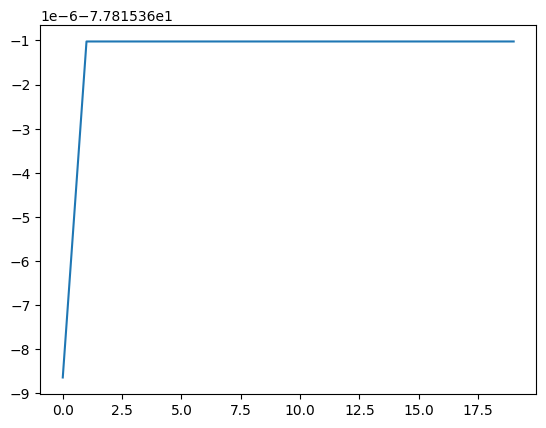

In [17]:
# lets plot the best fitness over generations
import matplotlib.pyplot as plt
plt.plot(history)